In [1]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec




In [2]:
install.packages("tzdb")

package 'tzdb' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'tzdb'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Irene\miniconda3\envs\r_boc\Lib\R\library\00LOCK\tzdb\libs\x64\tzdb.dll to C:\Users\Irene\miniconda3\envs\r_boc\Lib\R\library\tzdb\libs\x64\tzdb.dll: Permission denied"
Warning message:
"restored 'tzdb'"



The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\Rtmpqu9FiW\downloaded_packages


In [1]:
install.packages("readr")

package 'readr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'readr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Irene\miniconda3\envs\r_boc\Lib\R\library\00LOCK\readr\libs\x64\readr.dll to C:\Users\Irene\miniconda3\envs\r_boc\Lib\R\library\readr\libs\x64\readr.dll: Permission denied"
Warning message:
"restored 'readr'"



The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\RtmpELHvSt\downloaded_packages


In [4]:
gdp <- get_cansim("36-10-0103-01")

Accessing CANSIM NDM product 36-10-0103 from Statistics Canada



Parsing data



In [2]:
cpi <- get_cansim("18-10-0004-01")

Accessing CANSIM NDM product 18-10-0004 from Statistics Canada

Parsing data



In [50]:
cpi_vec <- get_cansim_vector_for_latest_periods("v41690914", periods = 300)

cpi_vec_adj <- cpi_vec|>
select("Date", "VALUE")|>
 mutate(
    # Get the CPI value from 12 months ago
    cpi_previous_year = lag(VALUE, 12),
    # Calculate the percentage change
    cpi_change = ((VALUE  / cpi_previous_year) - 1) * 100
  )

Accessing CANSIM NDM vectors from Statistics Canada



Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`)."


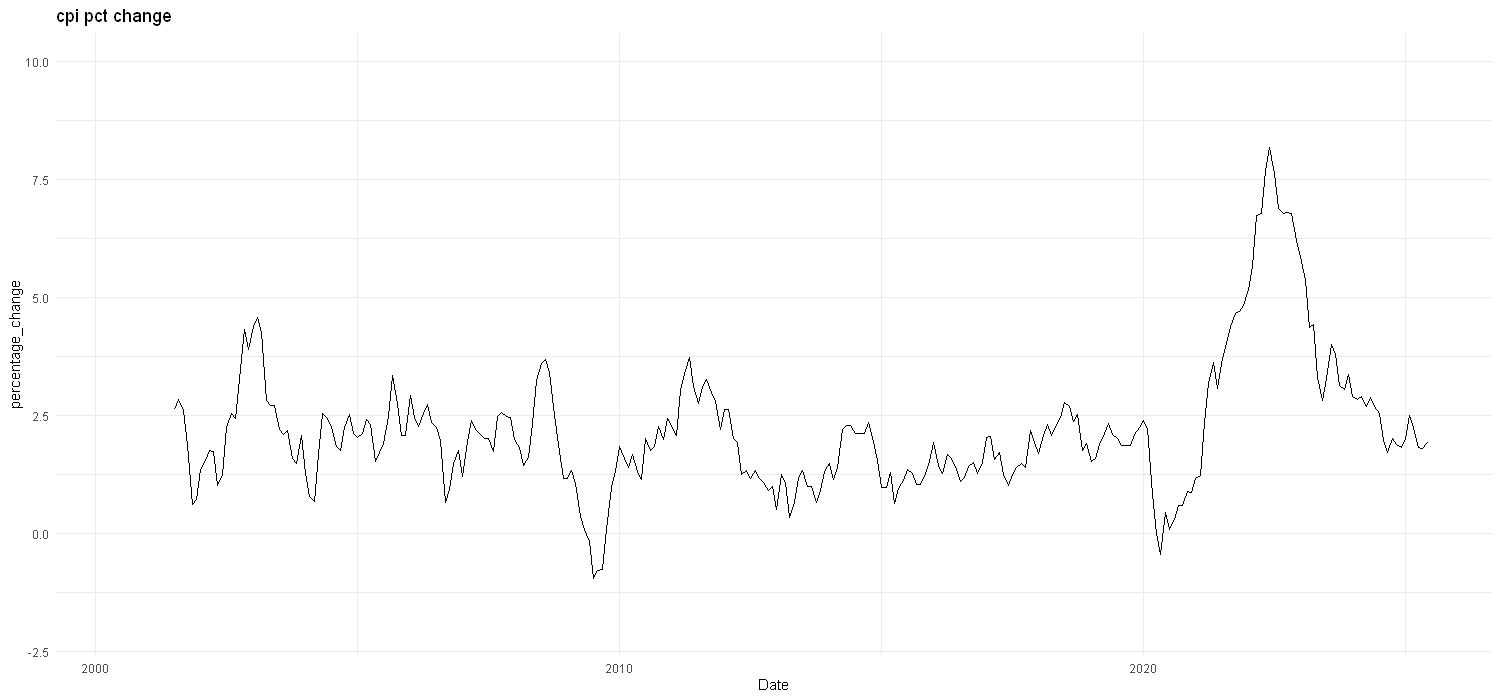

In [51]:
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100)

ggplot(cpi_vec_adj, aes(x = Date, y = cpi_change)) +
  geom_line() +
  labs(
    title = "cpi pct change",
    x = "Date",
    y = "percentage_change",
  ) +
  theme_minimal()+
  coord_cartesian(ylim = c(-2, 10))

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."


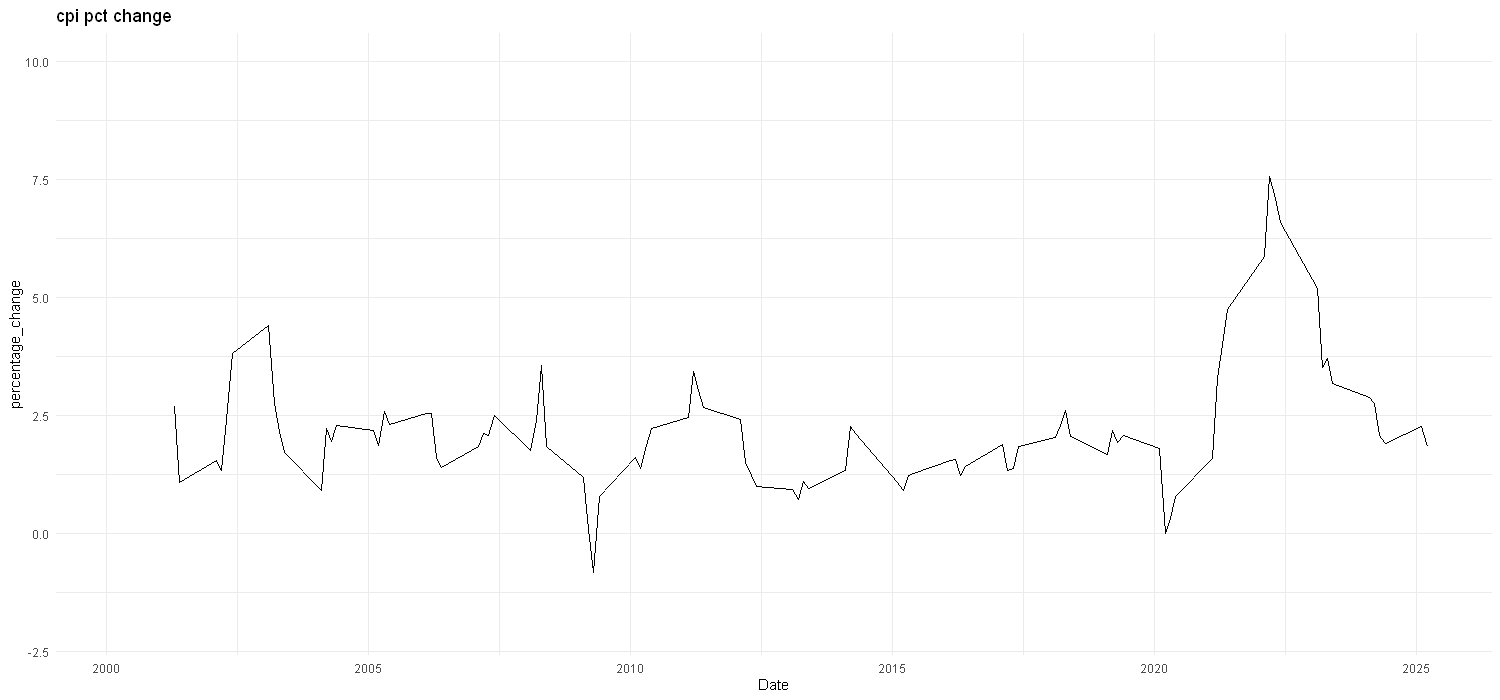

In [57]:
cpi_quarterly_adj <- cpi_vec |>
  select(Date, VALUE) |>
  # Create a new column for the quarter
  mutate(quarter = quarter(Date, with_year = TRUE)) |>
  # Group by quarter
  group_by(quarter) |>
  # Calculate the average CPI for each quarter
  summarise(VALUE = mean(VALUE, na.rm = TRUE)) |>
  ungroup() |>
  # Calculate the year-over-year percentage change for the quarterly data
  mutate(
    # Get the CPI value from 4 quarters ago (1 year)
    cpi_previous_year = lag(VALUE, 4),
    # Calculate the percentage change
    cpi_change = ((VALUE / cpi_previous_year) - 1) * 100
  )

options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100)

ggplot(cpi_quarterly_adj, aes(x = quarter, y = cpi_change)) +
  geom_line() +
  labs(
    title = "cpi pct change",
    x = "Date",
    y = "percentage_change",
  ) +
  theme_minimal()+
  coord_cartesian(ylim = c(-2, 10))


In [53]:
# Make sure dplyr is loaded
# install.packages("dplyr")
# install.packages("lubridate")
library(dplyr)
library(lubridate)

# Assuming 'cpi_vec' is your initial data frame with 'Date' and 'VALUE'

cpi_quarterly_stationary <- cpi_vec |>
  select(Date, VALUE) |>
  # Create a new column for the quarter
  mutate(quarter = quarter(Date, with_year = TRUE)) |>
  # Group by quarter
  group_by(quarter) |>
  # Calculate the average CPI for each quarter
  summarise(VALUE = mean(VALUE, na.rm = TRUE)) |>
  ungroup() |>
  # Calculate the quarter-over-quarter log difference (inflation rate)
  mutate(
    # Get the CPI value from the previous quarter
    cpi_previous_quarter = lag(VALUE, 1),
    # Calculate the log difference and multiply by 100 to get an approximate percentage
    delta_cpi = (log(VALUE) - log(cpi_previous_quarter)) * 100
  )

# View the result
print(cpi_quarterly_stationary)

# A tibble: 100 × 4
   quarter VALUE cpi_previous_quarter delta_cpi
     <dbl> <dbl>                <dbl>     <dbl>
 1   2000.  95.7                 NA     NA     
 2   2000.  96.7                 95.7    1.07  
 3   2001.  96.9                 96.7    0.241 
 4   2001.  98.2                 96.9    1.30  
 5   2001.  98.2                 98.2    0.0339
 6   2001.  97.7                 98.2   -0.510 
 7   2002.  98.4                 97.7    0.714 
 8   2002.  99.5                 98.4    1.08  
 9   2002. 101.                  99.5    1.10  
10   2002. 101.                 101.     0.858 
# ℹ 90 more rows


Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


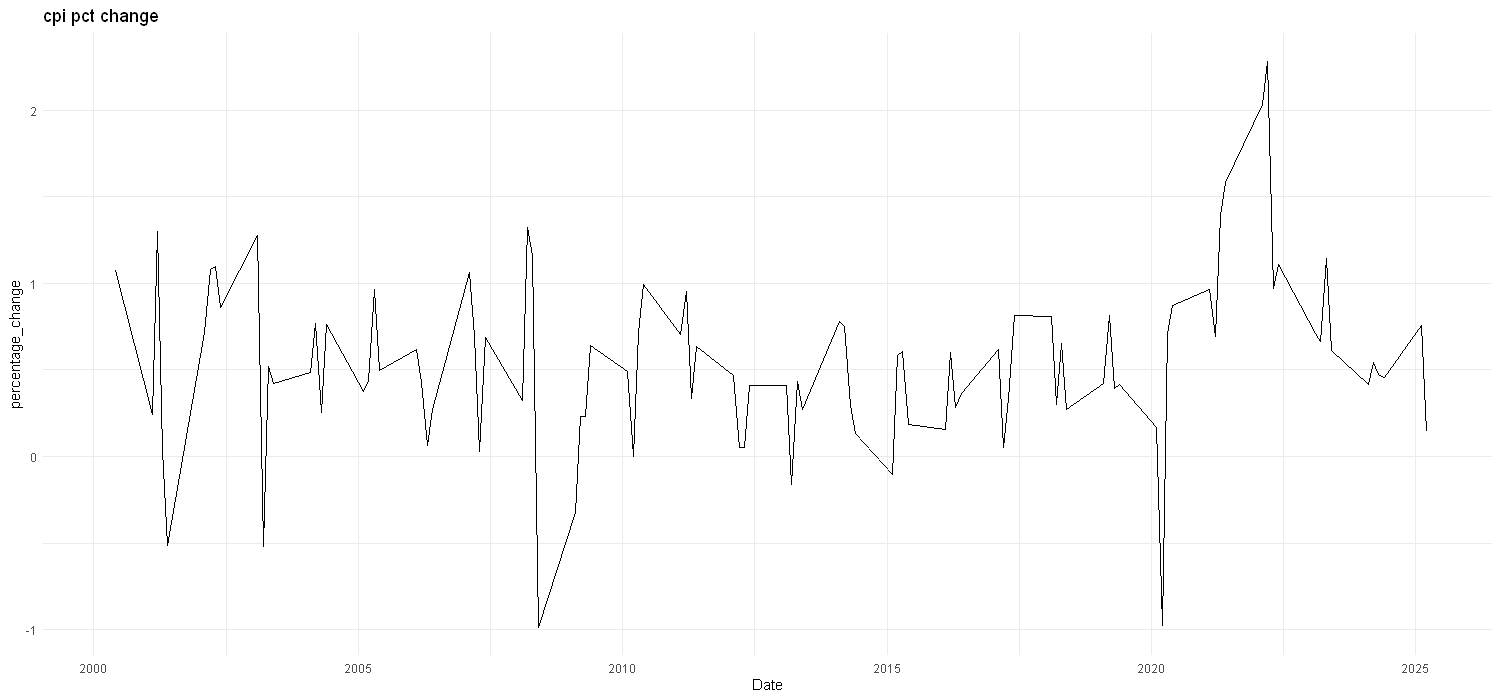

In [54]:
ggplot(cpi_quarterly_stationary, aes(x = quarter, y = delta_cpi)) +
  geom_line() +
  labs(
    title = "cpi pct change",
    x = "Date",
    y = "percentage_change",
  ) +
  theme_minimal()

In [43]:
install.packages("tseries")

also installing the dependencies 'xts', 'TTR', 'quadprog', 'quantmod'




package 'xts' successfully unpacked and MD5 sums checked
package 'TTR' successfully unpacked and MD5 sums checked
package 'quadprog' successfully unpacked and MD5 sums checked
package 'quantmod' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\RtmpyAjA48\downloaded_packages


In [44]:
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [58]:
adf_result <- adf.test(na.omit(cpi_quarterly_adj$cpi_change))

# Print the results
print(adf_result)


	Augmented Dickey-Fuller Test

data:  na.omit(cpi_quarterly_adj$cpi_change)
Dickey-Fuller = -2.819, Lag order = 4, p-value = 0.238
alternative hypothesis: stationary



In [59]:
adf_result <- adf.test(na.omit(cpi_quarterly_stationary$delta_cpi))

# Print the results
print(adf_result)


	Augmented Dickey-Fuller Test

data:  na.omit(cpi_quarterly_stationary$delta_cpi)
Dickey-Fuller = -3.0702, Lag order = 4, p-value = 0.1335
alternative hypothesis: stationary



In [60]:
cpi_post_pandemic <- cpi_quarterly_stationary |>
  filter(quarter >= 2020)

In [62]:
adf_result <- adf.test(na.omit(cpi_post_pandemic$delta_cpi))

# Print the results
print(adf_result)


	Augmented Dickey-Fuller Test

data:  na.omit(cpi_post_pandemic$delta_cpi)
Dickey-Fuller = -2.139, Lag order = 2, p-value = 0.5194
alternative hypothesis: stationary



In [63]:
# Assuming 'cpi_post_pandemic' is your filtered data frame
# First, create the first and second differences on this subset
cpi_post_pandemic_2nd_diff <- cpi_post_pandemic |>
  mutate(
    # First difference is already calculated, but we recalculate for a clean pipe
    cpi_previous_quarter = lag(VALUE, 1),
    delta_cpi = (log(VALUE) - log(cpi_previous_quarter)) * 100,
    
    # Now, calculate the second difference
    delta_cpi_previous_quarter = lag(delta_cpi, 1),
    delta2_cpi = delta_cpi - delta_cpi_previous_quarter
  )

# Run the ADF test on the new second-difference column
adf.test(na.omit(cpi_post_pandemic_2nd_diff$delta2_cpi))


	Augmented Dickey-Fuller Test

data:  na.omit(cpi_post_pandemic_2nd_diff$delta2_cpi)
Dickey-Fuller = -2.7152, Lag order = 2, p-value = 0.2999
alternative hypothesis: stationary
